In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cross support for windows and linux
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Load the data set and drop dubplicate. Add binary label
data_path = os.path.join(project_root, 'data', 'raw', 'fake_and_real_news.csv')

data = pd.read_csv(data_path)
mapping = {"Fake": 1, "Real": 0}
data["label_binary"] = data["label"].map(mapping)
data.drop_duplicates(subset="Text", inplace=True)

In [3]:
# Class for calculating average word vector of a article
from src.data_processing import WordEmbedder
we = WordEmbedder()

In [4]:
# Calculate mean vector for all articles in the dataset and add to it for testing purposes
data['vector'] = data["Text"].apply(lambda article: we.get_mean_vector(article))

In [5]:
data

,Text,label,label_binary,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,1,"[0.00858699, 0.019727645, -0.01165037, 0.03373..."
1,U.S. conservative leader optimistic of common ...,Real,0,"[0.00995244, 0.007760858, 0.0022168206, 0.0172..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,0,"[0.018229874, 0.0063075763, -0.0059792665, 0.0..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,1,"[0.012800121, 0.012192702, -0.00054181775, 0.0..."
4,Democrats say Trump agrees to work on immigrat...,Real,0,"[-0.001137371, 0.011028467, 0.003499095, 0.029..."
...,...,...,...,...
9895,Wikileaks Admits To Screwing Up IMMENSELY Wit...,Fake,1,"[0.008699299, 0.015413053, -0.004132382, 0.031..."
9896,Trump consults Republican senators on Fed chie...,Real,0,"[0.010093739, 0.0033310512, -0.0028811246, 0.0..."
9897,Trump lawyers say judge lacks jurisdiction for...,Real,0,"[0.0029755798, 0.004811713, 0.010553447, -0.00..."
9898,WATCH: Right-Wing Pastor Falsely Credits Trum...,Fake,1,"[0.0062270993, 0.015138365, -0.0007620977, 0.0..."


In [6]:
# Split dataset into training and testing set
from sklearn.model_selection import train_test_split

# using precalculated mean vectors
X = data['vector']
X_stacked = np.stack(X)
y = data['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X_stacked, y, test_size=.3, random_state=2024)

In [7]:
# Import reporting functions
from src.model_training import train_report
from sklearn.metrics import roc_curve, auc

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

# No params for comparison. Mean vectors
base_gbc = GradientBoostingClassifier()
train_report(base_gbc, "Base GBC", X_train, y_train, X_test, y_test)

Base GBC Report: 
              precision    recall  f1-score   support

        Real       0.98      0.99      0.98      1454
        Fake       0.99      0.98      0.98      1506

    accuracy                           0.98      2960
   macro avg       0.98      0.98      0.98      2960
weighted avg       0.98      0.98      0.98      2960

Confusion Matrix: 
[[1437   17]
 [  30 1476]]


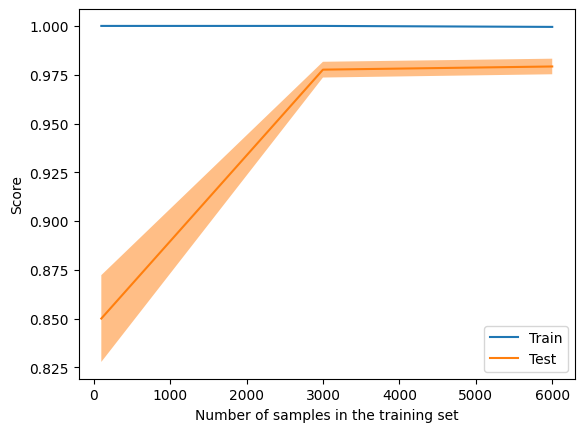

In [10]:
from sklearn.model_selection import LearningCurveDisplay
LearningCurveDisplay.from_estimator(GradientBoostingClassifier(), X_stacked, y, train_sizes=[100, 3000, 6000], cv=5)

In [12]:
pred = base_gbc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print(f"Base Model AUC Score: {roc_auc}")

Base Model AUC Score: 0.9841938984091146


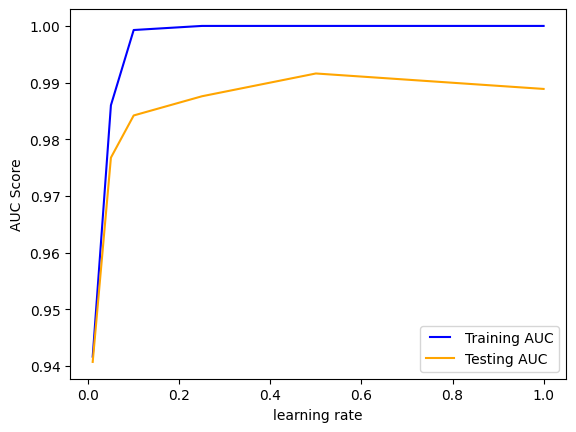

In [13]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_scores = []
test_scores = []

for x in learning_rates:
    model = GradientBoostingClassifier(learning_rate=x)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_scores.append(roc_auc)

    test_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_scores.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_scores, "b", label="Training AUC")
line2, = plt.plot(learning_rates, test_scores, color="orange", label="Testing AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("learning rate")
plt.show()

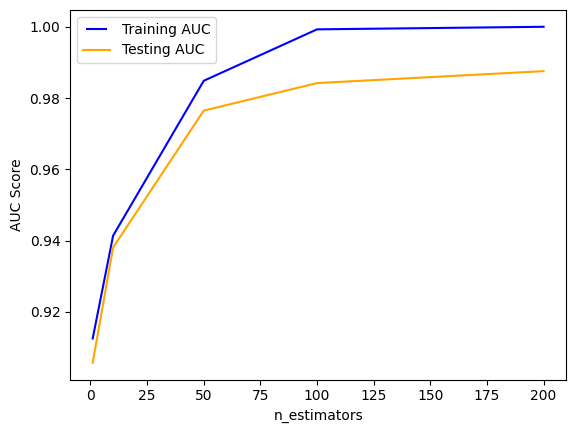

In [16]:
n_estimators = [1, 10, 50, 100, 200]
train_scores = []
test_scores = []

for x in n_estimators:
    model = GradientBoostingClassifier(n_estimators=x)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_scores.append(roc_auc)

    test_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_scores.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_scores, "b", label="Training AUC")
line2, = plt.plot(n_estimators, test_scores, color="orange", label="Testing AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("n_estimators")
plt.show()

In [ ]:
max_depth = []
train_scores = []
test_scores = []

for x in n_estimators:
    model = GradientBoostingClassifier(n_estimators=x)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    train_scores.append(roc_auc)

    test_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    test_scores.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_scores, "b", label="Training AUC")
line2, = plt.plot(n_estimators, test_scores, color="orange", label="Testing AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC Score")
plt.xlabel("n_estimators")
plt.show()

In [17]:
X_train_sampled = X_train[:3000]
y_train_sampled = y_train[:3000]

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid_estimators = {
    'n_estimators': range(20, 80, 10)
}

grid_search = GridSearchCV(GradientBoostingClassifier(learning_rate=.05, random_state=2024), param_grid_estimators, cv=4, scoring='roc_auc', n_jobs=4)
grid_search.fit(X_train_sampled, y_train_sampled)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'n_estimators': 70}
Best Cross-Validation Accuracy: 0.9930700398260399


In [25]:
for i in ['mean_test_score', 'std_test_score', 'param_n_estimators']:
    print(i," : ",grid_search.cv_results_[i])

mean_test_score  :  [0.9803421  0.98520479 0.98823316 0.99020881 0.99177546 0.99307004]
std_test_score  :  [0.00590321 0.00473693 0.00354109 0.00324775 0.00297466 0.00249434]
param_n_estimators  :  [20 30 40 50 60 70]


In [29]:
final_gbc = GradientBoostingClassifier(learning_rate=.05, n_estimators=70)

In [30]:
train_report(final_gbc, "GBC: lr.05, n_est=70", X_train_sampled, y_train_sampled, X_test, y_test)

GBC: lr.05, n_est=70 Report: 
              precision    recall  f1-score   support

        Real       0.96      0.97      0.97      1454
        Fake       0.98      0.96      0.97      1506

    accuracy                           0.97      2960
   macro avg       0.97      0.97      0.97      2960
weighted avg       0.97      0.97      0.97      2960

Confusion Matrix: 
[[1417   37]
 [  57 1449]]


In [31]:
train_report(GradientBoostingClassifier(), "Base version", X_train_sampled, y_train_sampled, X_test, y_test)

Base version Report: 
              precision    recall  f1-score   support

        Real       0.98      0.98      0.98      1454
        Fake       0.98      0.98      0.98      1506

    accuracy                           0.98      2960
   macro avg       0.98      0.98      0.98      2960
weighted avg       0.98      0.98      0.98      2960

Confusion Matrix: 
[[1431   23]
 [  32 1474]]


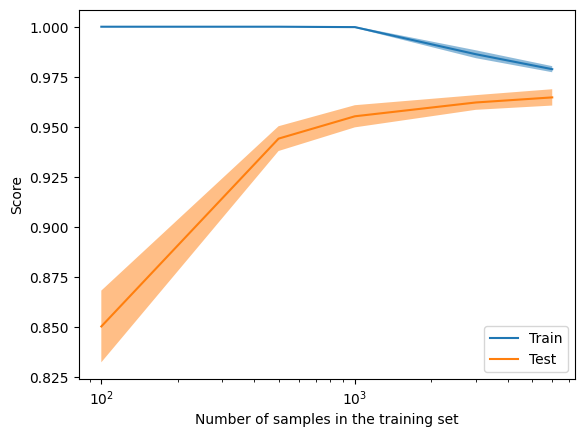

In [33]:
LearningCurveDisplay.from_estimator(GradientBoostingClassifier(learning_rate=.05, n_estimators=70), X_stacked, y, train_sizes=[100, 500, 1000, 3000, 6000], cv=5)